<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/shruti-working/image_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [20]:
%%capture
!pip -q install rasterio
#!pip -q install torch
#!pip -q install torchvision
#!pip -q install albumentations
#!pip -q install segmentation-models-pytorch
#!pip -q install tqdm
!pip install osmnx
!pip install pyrosm

In [58]:
%%capture
!pip install wget

In [48]:
import os
import re
#import torch
import rasterio
import rasterio.features
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio.plot import show
import json
from shapely.geometry import LineString, Polygon, GeometryCollection
#import albumentations as A
#from torch.utils import data
#from torch.utils.data import Dataset, DataLoader
#import segmentation_models_pytorch as smp
#from torchvision import transforms as T
#from albumentations.pytorch import ToTensorV2
#import torch.nn as nn
#import torch.nn.functional as F
#import torchsummary
#from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
#from PIL import Image
#import imageio
import numpy as np
#import cv2
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
import pandas as pd
import osmnx as ox
import geopandas as gpd



# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download  data to local compute node

## Mount your Google Drive

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path 'zindi-amazon-secret-runway' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


## Download OSM data for Peru

The code below takes a few minutes to run. But it only needs to be run once as long as the session is active.

## Compress files, copy over to compute node, and uncompress

In [4]:
# Navigate to the shared directory
#%cd /content/drive/MyDrive/Zindi-Amazon/
#!zip -r /content/predictions.zip WhateverDirectory
#!unzip /content/predictions.zip -d /content

# Description of process

Here's a method to identify clusters, fit lines to each one, and extract the endpoints and lengths. We'll start by identifying clusters, then fit lines to each, and finally calculate endpoints and filter based on length-to-width ratios.

**Step-by-Step Method:**
1.   **Identify Clusters:** We can identify clusters of connected pixels in the binary mask using connected component analysis. Each cluster corresponds to a connected component in the binary mask.
2.   **Fit a Line to Each Cluster:** For each identified cluster, fit a line using Principal Component Analysis (PCA), which will help determine the main axis of elongation for the cluster. The endpoints of the fitted line can be computed along this principal component.
3.   **Extract Lengths and Calculate Length/Width Ratios:** Once we have the principal component direction, calculate the length of the line by projecting the points onto the main axis. The width can be computed as the spread of points orthogonal to this main axis, allowing for length-to-width ratio calculations.
4.   **Reject bad clusters:** Airstrips are long and narrow. In the training set, the shortest LINESTRING was 376 meters. With a 20-meter buffer, the mininal lenght of the prediction shoud be over 400 meters. If we reject all clusters that do not intersect the bounding box, and are less than 300 meters long (30 pixels), we shoud remove almost all short road or dry river bed segments. For clusters that intersect the bounding box, we are not going to cut them based on the line segment lenght. If it looks like a problem, we'll devise a different cut.


In [9]:
# @title
def process_clusters(binary_mask, min_length=30, max_width=6):
    """
    Identifies and processes clusters (connected components) in the binary mask.
    """

    # Label connected components in the mask
    labeled_mask = label(binary_mask)
    clusters = regionprops(labeled_mask)
    image_height, image_width = binary_mask.shape  # Get image dimensions

    lines = []

    for cluster in clusters:
        # Check if the cluster has enough points for PCA
        if cluster.area < 2:  # At least 2 points needed for PCA
            # Handle clusters with insufficient points (e.g., skip, merge, etc.)
            print(f"Skipping cluster with {cluster.area} points - insufficient for PCA.")
            continue  # Skip this cluster

        # Extract the coordinates of the pixels in the cluster
        coords = cluster.coords

        # Perform PCA to find the main axis
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        variance = pca.explained_variance_

        # Compute the length of the cluster along the principal axis
        projected_coords = coords @ direction
        min_proj, max_proj = projected_coords.min(), projected_coords.max()
        length = max_proj - min_proj

        # Calculate width by projecting orthogonal to main axis
        orthogonal_direction = pca.components_[1]
        orthogonal_proj = coords @ orthogonal_direction
        width = orthogonal_proj.max() - orthogonal_proj.min()

        # Compute length-to-width ratio
        length_width_ratio = length / width if width != 0 else np.inf

        # Check if line touches the border:
        touches_border = any(
            (x == 0 or x == image_width - 1 or y == 0 or y == image_height - 1)
            for x, y in coords
        )


        # Filter based on length and border condition and width
        if (width <= max_width) and ((length >= min_length and not touches_border) or (touches_border)):
            # Get endpoints of the line along the main axis
            endpoint1 = pca.mean_ + direction * (min_proj - pca.mean_ @ direction)
            endpoint2 = pca.mean_ + direction * (max_proj - pca.mean_ @ direction)
            lines.append({
                "length": length,
                "width": width,
                "ratio": length_width_ratio,
                "endpoints": (endpoint1, endpoint2)
            })

    return lines

In [62]:
def plot_clusters_and_lines(binary_mask, base_image, lines, roads):
    plt.figure(figsize=(10,10))  # Set figure size

    # If the base image is in (bands, height, width) format, convert to (height, width, channels)
    if base_image.ndim == 3 and base_image.shape[0] in [3, 4]:  # Assuming 3 or 4 bands
        base_image = np.transpose(base_image, (1, 2, 0))  # (bands, height, width) -> (height, width, bands)

    # Normalize and display the base image
    if base_image.ndim == 3:
        base_image = (base_image - base_image.min()) / (base_image.max() - base_image.min())  # Normalize for display
        plt.imshow(base_image, cmap="gray", alpha=0.5)
    else:
        plt.imshow(base_image, cmap="gray", alpha=0.5)

    plt.imshow(binary_mask, cmap="gray", alpha=0.5)

    # Plot the reprojected road network
    plt.imshow(roads, cmap="YlGn", alpha=0.5)

    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]
        plt.plot([y1, y2], [x1, x2], 'r-')

    plt.show()


In [11]:
# @title
def load_binary_mask_from_geotiff(geotiff_path):
    """
    Loads the binary mask from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(geotiff_path) as src:
        # Read the first band (assuming the binary mask is single-band and in the first band)
        binary_mask = src.read(1)

    # Ensure mask is binary (values should be 0 or 1)
    binary_mask = (binary_mask > 0).astype(np.uint8)

    return binary_mask


In [12]:
# @title
def lines_to_geojson(lines, geotiff_path, buffer_distance=200):
    """
    Converts lines with pixel coordinates to GeoJSON LINESTRING features
    using the GeoTIFF metadata, including the CRS.

    Args:
        lines: A list of line dictionaries, each with "endpoints" key.
        geotiff_path: Path to the GeoTIFF file.
        buffer_distance: Buffer distance in meters.

    Returns:
        A GeoJSON FeatureCollection containing the Polygon features with buffer.
    """

    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        crs = src.crs

    features = []
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]

        # Convert pixel coordinates to geographic coordinates
        lon1, lat1 = rasterio.transform.xy(transform, x1, y1)
        lon2, lat2 = rasterio.transform.xy(transform, x2, y2)

        # Create Shapely LineString
        line_geom = LineString([(lon1, lat1), (lon2, lat2)])

        # Buffer the LineString (assuming UTM coordinates)
        polygon_geom = line_geom.buffer(buffer_distance)

        # Create GeoJSON Polygon feature
        feature = {
            "type": "Feature",
            "geometry": polygon_geom.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"]
            }
        }
        features.append(feature)

    # Create GeoJSON FeatureCollection with CRS
    geojson = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {
            "type": "name",
            "properties": {
                "name": crs.to_string()  # Get CRS as a string
            }
        }
    }

    return geojson


In [13]:
# @title
def create_mask_from_geojson(geojson_data, geotiff_path, output_path):
    """
    Creates a new GeoTIFF mask from GeoJSON polygons,
    using the metadata of an existing GeoTIFF.

    Args:
        geojson_data: The GeoJSON data containing the polygons.
        geotiff_path: Path to the original GeoTIFF file.
        output_path: Path to save the new GeoTIFF mask.
    """

    with rasterio.open(geotiff_path) as src:
        # Get metadata from original GeoTIFF
        meta = src.meta.copy()

        # Update data type to uint8 for binary mask
        meta.update(dtype=rasterio.uint8, count=1, nodata=None)

        # Create an empty mask array
        mask = np.zeros((meta['height'], meta['width']), dtype=rasterio.uint8)

        # Rasterize GeoJSON polygons onto the mask with value 1
        for feature in geojson_data['features']:
            # Burn the polygon with a value of 1
            # Use rasterio.features.rasterize instead of features.rasterize
            rasterio.features.rasterize(
                [(feature['geometry'], 1)],
                out=mask,
                transform=meta['transform'],
                all_touched=True,
                default_value=1,  # Set polygon value to 1
                dtype=rasterio.uint8,
            )

        # Write the new mask to a GeoTIFF file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(mask, indexes=1)


In [14]:
# @title
def create_dataframe_from_mask(mask_path, aoi_file):
    """
    Creates a Pandas DataFrame from a GeoTIFF mask file,
    extracting pixels with value 1.

    Args:
        mask_path: Path to the GeoTIFF mask file.
        aoi_file: Name of the AOI file (used in the DataFrame index).

    Returns:
        A Pandas DataFrame with columns 'pixel_id' and 'value'.
    """

    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # Read the mask data as a NumPy array

    # Get indices of pixels with value 1
    row_indices, col_indices = np.where(mask_data == 1)

    # Create a list of pixel IDs in the specified format
    pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(row_indices, col_indices)]

    # Create the DataFrame
    df = pd.DataFrame({'tile_row_column': pixel_ids, 'label': 1})
    df.set_index('tile_row_column', inplace=True)

    return df

In [15]:
# @title
def export_dataframe_to_csv(df, csv_path):
    """
    Exports a Pandas DataFrame to a CSV file, appending if the file exists.

    Args:
        df: The Pandas DataFrame to export.
        csv_path: Path to the CSV file.
    """

    # Check if the file exists
    if os.path.exists(csv_path):
        # Append to the existing file without header
        df.to_csv(csv_path, mode='a', header=False, index=True)
    else:
        # Create a new file with header
        df.to_csv(csv_path, mode='w', header=True, index=True)


In [16]:
# @title
def extract_model_bands(text):
    """
    Extracts the part of the string after "lr0005".

    Args:
      text: The input string.

    Returns:
      The part of the string after "lr0005", or None if "lr0005" is not found.
    """
    match = re.search(r"lr0005_(.*)", text)
    if match:
        return match.group(1)
    else:
        return None


In [17]:
# @title
def modify_string_for_submission_file(input_string):
    """
    Removes "20" from the input string if it's in the format "aoi_20YY_MM".

    Args:
      input_string: The input string.

    Returns:
      The modified string with "20" removed, or the original string if
      it doesn't match the expected format.
    """
    return re.sub(r"aoi_20(\d\d)_(\d\d)", r"aoi_\1_\2", input_string)


In [18]:
# @title
def load_inference_image(inference_path):
    """
    Loads the inference image from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(inference_path) as src:
        multiband_image = src.read([1, 2, 3])
    return multiband_image


In [59]:
def load_osm_roads(aoi_name):
    aoiboundary = get_aoi_boundary(aoi_name)

    # Set crs
    from_crs = aoiboundary.crs
    to_crs = 'EPSG:4326'

    # Reproject the GeoDataFrame
    aoiboundary_epsg4326 = aoiboundary.to_crs(to_crs)

    # Use geographic coordinates to extract osm data
    min_x, min_y, max_x, max_y = aoiboundary_epsg4326.total_bounds
    bbox = (max_y, min_y, max_x, min_x) # (north, south, east, west)

    # Download and filter OSM road data within the bounding box
    roads_epsg4326 = ox.features_from_bbox(bbox=bbox, tags={'highway': True})

    # Reproject the road network back to aoi crs
    roads = roads_epsg4326.to_crs(from_crs)

     # Clip the roads to the original AOI boundary to match the extent exactly
    roads_clipped = gpd.clip(roads, aoiboundary)

    # Convert roads to a rasterized NumPy array
    return roads_to_array(roads_clipped, aoiboundary)

In [49]:
# @title
def roads_to_array(roads_clipped, aoiboundary, pixel_size=10):
    """
    Rasterizes the roads GeoDataFrame to a NumPy array.

    Parameters:
    - roads_clipped: GeoDataFrame of roads clipped to AOI.
    - aoiboundary: GeoDataFrame of AOI boundary.
    - pixel_size: Size of each pixel in the output array.

    Returns:
    - A NumPy array with the rasterized roads.
    """
    # Get the bounding box of the AOI boundary
    min_x, min_y, max_x, max_y = aoiboundary.total_bounds

    # Calculate the shape of the output array
    width = int((max_x - min_x) / pixel_size)
    height = int((max_y - min_y) / pixel_size)

    # Define the transform for the array
    transform = from_bounds(min_x, min_y, max_x, max_y, width, height)

    # Rasterize the roads into a NumPy array
    roads_array = rasterize(
        [(geometry, 1) for geometry in roads_clipped.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,         # Fill the background with 0
        dtype='uint8',  # Use an unsigned 8-bit integer array
        all_touched=True  # Include all pixels touched by lines
    )

    return roads_array

In [8]:
# @title
# Read data using GeoPandas
def get_aoi_boundary(aoi_name):
    base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'
    shapefile = os.path.join(base_aoi_path, f'{aoi_name}.shp')
    aoiboundary = gpd.read_file(shapefile)
    return aoiboundary

# Main loop

This is where we load the GeoTIFF file prediction, find the clusters,
clean the image and then produce a final prediction. Notice that the final prediction must have a 200 meter buffer.

Processing aoi_2021_01


<ipython-input-59-e9d0d8b3c610>:16: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  roads_epsg4326 = ox.features_from_bbox(bbox=bbox, tags={'highway': True})


Skipping cluster with 1.0 points - insufficient for PCA.


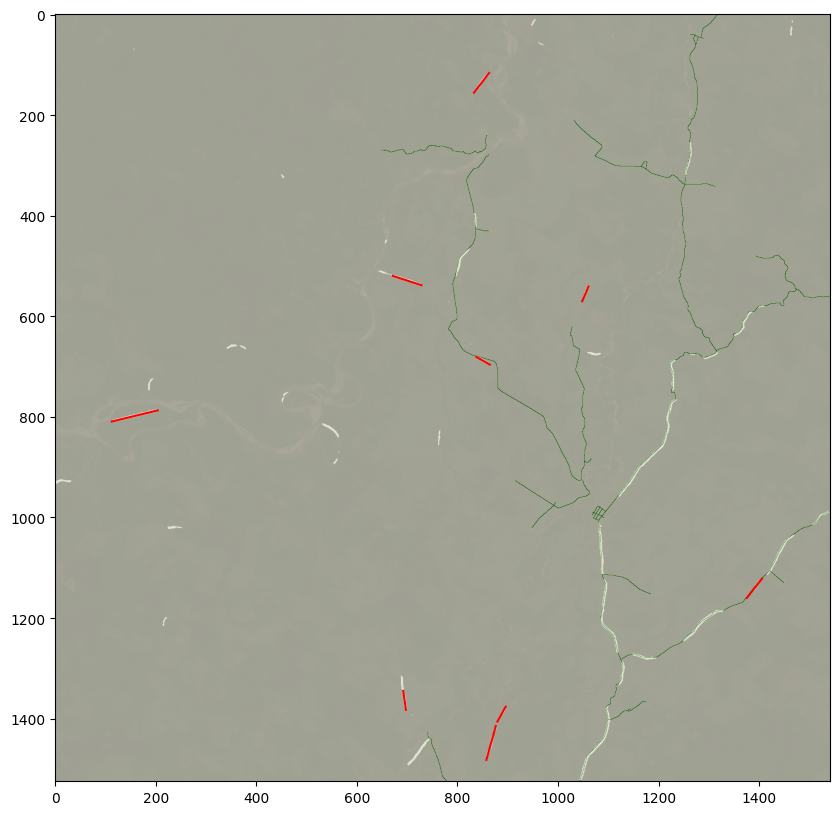

 Length: 49.02463240604533, Width: 5.563542487074187, Ratio: 8.811765618748227
 Endpoints: (array([116.26914579, 863.05561073]), array([155.03976515, 833.05138341]))
 Length: 59.43732738908625, Width: 5.429306782985179, Ratio: 10.947498412754271
 Endpoints: (array([519.72898949, 671.76413758]), array([538.02590921, 728.31516423]))
 Length: 31.777151792037245, Width: 4.307405287578831, Ratio: 7.377330357947118
 Endpoints: (array([ 540.86908089, 1060.69621639]), array([ 570.05157645, 1048.11967755]))
 Length: 30.39017062733933, Width: 4.476561408669568, Ratio: 6.788730870190671
 Endpoints: (array([680.90971224, 838.05143006]), array([695.95151876, 864.45799226]))
 Length: 93.85723194770083, Width: 5.5635085242888636, Ratio: 16.870151548783294
 Endpoints: (array([809.11417465, 112.78518046]), array([786.99421148, 203.99859624]))
 Length: 49.03487484218506, Width: 4.921693678212705, Ratio: 9.963008274824592
 Endpoints: (array([1121.72690182, 1405.65440352]), array([1160.1995114 , 1375.2524

In [63]:
# @title
#aoi_files = ['aoi_2020_01', 'aoi_2020_02', 'aoi_2020_03', 'aoi_2021_01', 'aoi_2021_02', 'aoi_2021_03', 'aoi_2021_04', 'aoi_2022_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2024_01']
aoi_files = ['aoi_2021_01']
aoi_directory = '/content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_B8_VV'

for aoi_file in aoi_files:
    print(f'Processing {aoi_file}')
    geotiff_path = f'{aoi_directory}/{aoi_file}_prediction_mosaic.tif'
    inference_path = f'/content/drive/MyDrive/Zindi-Amazon/inference/Sentinel_AllBands_Inference_{aoi_file.split("aoi_")[1]}.tif'

    roads = load_osm_roads(aoi_file)

    binary_mask = load_binary_mask_from_geotiff(geotiff_path)
    inference_image = load_inference_image(inference_path)
    lines = process_clusters(binary_mask)

    plot_clusters_and_lines(binary_mask, inference_image, lines, roads)

    # Output the line information
    for line in lines:
        print(f" Length: {line['length']}, Width: {line['width']}, Ratio: {line['ratio']}")
        print(f" Endpoints: {line['endpoints']}")

    # Convert lines to GeoJSON object.
    geojson_data = lines_to_geojson(lines, geotiff_path)

    # Get model bands stored in name of the directory.
    bands = extract_model_bands(aoi_directory)

    # Create final mask with padding.
    create_mask_from_geojson(geojson_data, geotiff_path, f'{aoi_file}_{bands}_prediction_final.tif')

    submission_tag = modify_string_for_submission_file(aoi_file)
    df = create_dataframe_from_mask(f'{aoi_file}_{bands}_prediction_final.tif', submission_tag)
    #print(df)

    csv_path = f'output_file_{bands}.csv'  # Path to your CSV file
    export_dataframe_to_csv(df, csv_path)
